In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import ttest_ind
from numpy import median
import pickle


In [2]:
# Make dictionaries for converting between sequence IDs

# Need list of proteins for each family
enzyme_order_df = pd.read_excel("data/initial_enzymes_1.xlsx")
sp_df = pd.read_excel("data/sp_prot_translations.xls")

# Map true protein ids
enzyme_order_df['prot_seq_trunc'] = enzyme_order_df['Protein-met-sigp'].str[:80]
sp_df['prot_seq_trunc'] = sp_df['prot_seq'].str[1:81]
merge_df = enzyme_order_df.merge(sp_df, how='inner', on='prot_seq_trunc')

# merge_df[['enzyme_id','enzyme_type','seqID', 'new_id']]

# Get shuffled enzyme ID list back out
enzIDkeydf = merge_df[['enzyme_id','enzyme_type','seqID', 'new_id']]

seq2enzyme = pd.Series(enzIDkeydf.enzyme_id.values, index= enzIDkeydf.seqID).to_dict()
seq2family = pd.Series(enzIDkeydf.enzyme_type.values, index= enzIDkeydf.seqID).to_dict()
seq2newid = pd.Series(enzIDkeydf.new_id.values, index= enzIDkeydf.seqID).to_dict()
newid2seq = pd.Series(enzIDkeydf.seqID.values, index= enzIDkeydf.new_id).to_dict()

In [3]:
df = pd.read_csv('data/preprocessed.csv')
df['run_index'] = [i for i in range(len(df))]
df = df.drop(columns=['Unnamed: 0'])

In [4]:
# Make data tidy
tidy_df = df.melt(id_vars=['correct', 'protein_id', 'sp_id', 'run_label', 'true_prot_id', 'prot_correct', 'sp_correct', 'family', 'run_id', 'run_index'], 
                  var_name='assay', value_name='assay_value')
tidy_df.rename(columns={'true_prot_id':'seqID'}, inplace=True)
tidy_df = tidy_df.sort_values(by = 'run_id', ascending = True).dropna()

# Rescreen Column remapping
remap_dict = {'amylase_2_10x': 'amylase_10x',
              'amylase_1_10x': 'amylase_10x',
              'positive_amy_10x': 'amylase_10x',
              'positive_xyl_50x': 'xylanase_50x',
              'xylanase_1_50x': 'xylanase_50x',
    
}
tidy_df['family'].replace(remap_dict, inplace=True)

In [5]:
# Create new 'correct' column based on results from pairwise alignments, which found more SPs
def combine_cols(row):
    if row["prot_correct"] == True and row["sp_correct"] == True:
        return True
    else:
        return False

tidy_df['old_correct'] = tidy_df['correct'].values
tidy_df['correct'] = tidy_df.apply(lambda x: combine_cols(x), axis=1)

In [6]:
rescreen_fams = [fam for fam in list(set(tidy_df['family'].values)) if fam[-2:] == '0x']
all_fams = [fam for fam in list(set(tidy_df['family'].values))]
reg_fams = [fam for fam in all_fams if fam not in rescreen_fams]
print(all_fams)
print(rescreen_fams)
print(reg_fams)

['amylase', 'negative', 'xylanase_50x', 'protease', 'amylase_10x', 'positive', 'xylanase', 'lipase']
['xylanase_50x', 'amylase_10x']
['amylase', 'negative', 'protease', 'positive', 'xylanase', 'lipase']


In [7]:
# Remove rescreens
tidy_df = tidy_df[tidy_df['run_id'] != '26_15-2']
tidy_df = tidy_df[tidy_df['family'].isin(rescreen_fams)]
set(tidy_df['family'].values)

{'amylase_10x', 'xylanase_50x'}

In [8]:
# Need list of proteins for each family
enzyme_order_df = pd.read_excel("data/initial_enzymes_1.xlsx")
sp_df = pd.read_excel("data/sp_prot_translations.xls")

# Map true protein ids
enzyme_order_df['prot_seq_trunc'] = enzyme_order_df['Protein-met-sigp'].str[:80]
sp_df['prot_seq_trunc'] = sp_df['prot_seq'].str[1:81]
merge_df = enzyme_order_df.merge(sp_df, how='inner', on='prot_seq_trunc')

merge_df[['enzyme_id','enzyme_type','seqID', 'new_id']]

# Get shuffled enzyme ID list back out
enzIDkeydf = merge_df[['enzyme_id','enzyme_type','seqID', 'new_id']]

In [9]:
tidy_df.head(2)

,correct,protein_id,sp_id,run_label,seqID,prot_correct,sp_correct,family,run_id,run_index,assay,assay_value,old_correct
1777,True,Arnold_038,sps10-1,xylanase_1_50x,seq10,True,True,xylanase_50x,10_10-1,618,assay_2_value,0.648,True
618,True,Arnold_038,sps10-1,xylanase_1_50x,seq10,True,True,xylanase_50x,10_10-1,618,assay_1_value,0.324,True


In [10]:
seq2newid2 = pickle.load(open("data/final_plot_ids_2.p", "rb"))

with open('data/final_sp_plot_dict.p','rb') as f:
    sp_plot_id = pickle.load(f)

def get_new_id(row, include_prot=False):
    if row['run_id'] == 'false_construct':
        return 'incorrect construct'
    
    else:
        old_id = row['run_id'].split('_')

        if len(old_id) == 3: # then it's a control
            prot, sp, _ = old_id

            if old_id[-1] == 'neg':
                new_id = 'random_' + sp
            elif old_id[-1] == 'pos':
                try:
                    new_id = seq2newid2[sp]
                except KeyError:
                    new_id = 'incorrect construct pos'
    #                 print(old_id)
            else:
                raise ImplementationError

        elif len(old_id) == 2:
#             prot, sp = old_id
#             sp_ref, sp_num = sp.split('-')
#             new_id = seq2newid2[sp_ref] + '-' + sp_num
            new_id = sp_plot_id[row['sp_id']]
            
        else:
            raise ImplementationError

        if include_prot:
            new_id = seq2newid2[prot] + '_' + new_id

        return new_id

tidy_df['plot_id'] = tidy_df.apply(lambda row: get_new_id(row), axis=1)
tidy_df[(tidy_df['plot_id'] == 'incorrect_construct_pos') & (tidy_df['correct']==True)]
tidy_df

,correct,protein_id,sp_id,run_label,seqID,prot_correct,sp_correct,family,run_id,run_index,assay,assay_value,old_correct,plot_id
1777,True,Arnold_038,sps10-1,xylanase_1_50x,seq10,True,True,xylanase_50x,10_10-1,618,assay_2_value,0.648,True,Gen_037
618,True,Arnold_038,sps10-1,xylanase_1_50x,seq10,True,True,xylanase_50x,10_10-1,618,assay_1_value,0.324,True,Gen_037
2936,True,Arnold_038,sps10-1,xylanase_1_50x,seq10,True,True,xylanase_50x,10_10-1,618,assay_3_value,0.340,True,Gen_037
1837,True,Arnold_038,sps10-2,xylanase_1_50x,seq10,True,True,xylanase_50x,10_10-2,678,assay_2_value,0.356,True,Gen_038
678,True,Arnold_038,sps10-2,xylanase_1_50x,seq10,True,True,xylanase_50x,10_10-2,678,assay_1_value,0.342,True,Gen_038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,True,Arnold_037,sps9-4,xylanase_1_50x,seq9,True,True,xylanase_50x,9_9-4,639,assay_2_value,0.766,True,Gen_036
2957,True,Arnold_037,sps9-4,xylanase_1_50x,seq9,True,True,xylanase_50x,9_9-4,639,assay_3_value,0.694,True,Gen_036
1774,True,Arnold_037,sps9-4,xylanase_1_50x,seq9,True,True,xylanase_50x,9_9-4,615,assay_2_value,0.672,True,Gen_036
1762,True,Arnold_037,sps9-4,xylanase_1_50x,seq9,True,True,xylanase_50x,9_9-4,603,assay_2_value,0.530,True,Gen_036


In [11]:
prot_fams = ['amylase_10x', 'xylanase_50x']

In [12]:
## Visualize negative controls

In [13]:
run_ix_classification = pickle.load(open('data/200225_runix_classification.p', 'rb'))
existing_keys = run_ix_classification.keys()
for run_ix in list(set(tidy_df['run_index'].values)):
    if run_ix not in existing_keys:
        run_ix_classification.update({run_ix:'Not Functional'})

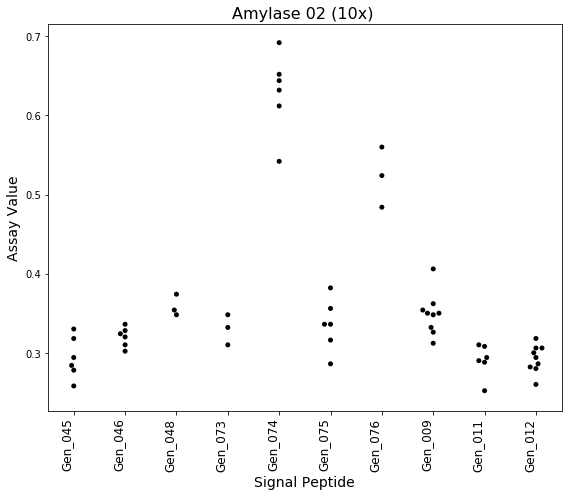

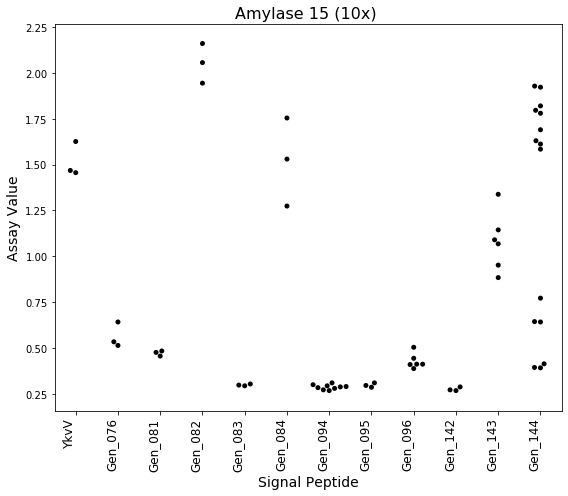

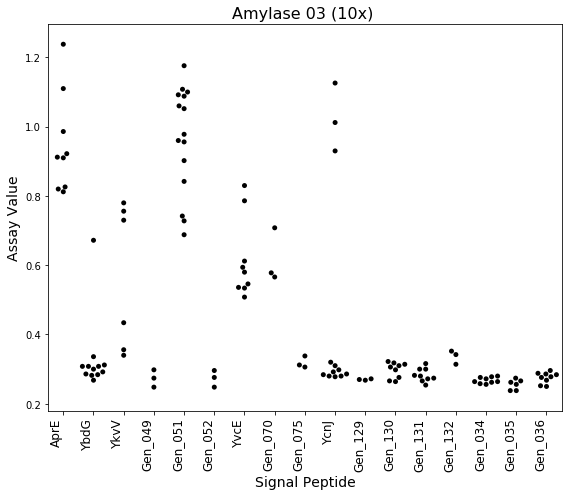

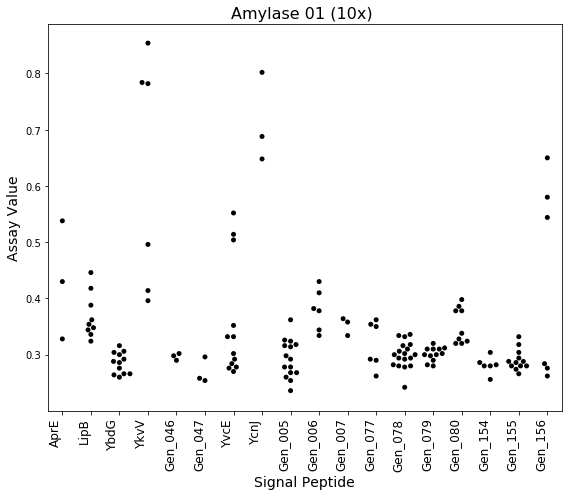

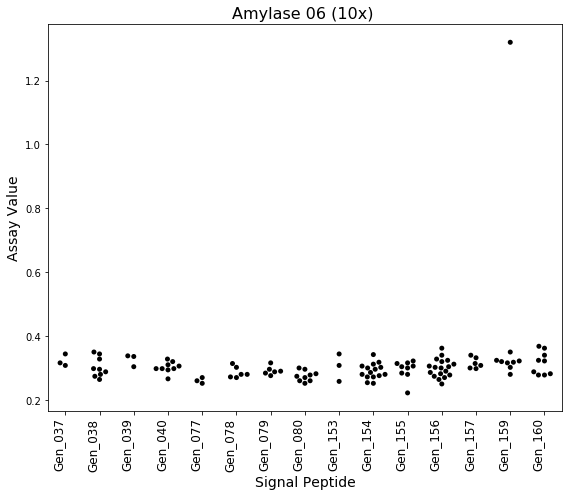

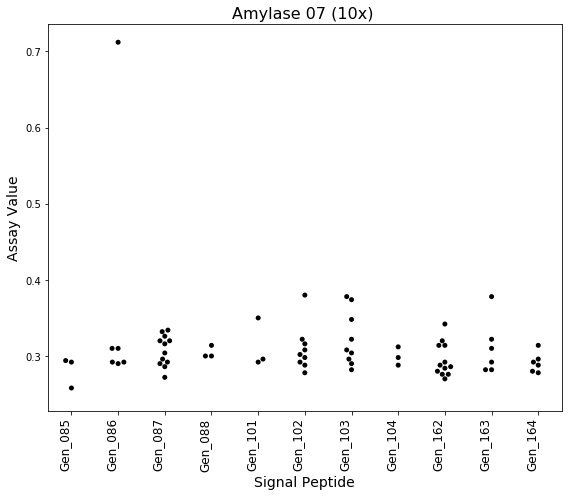

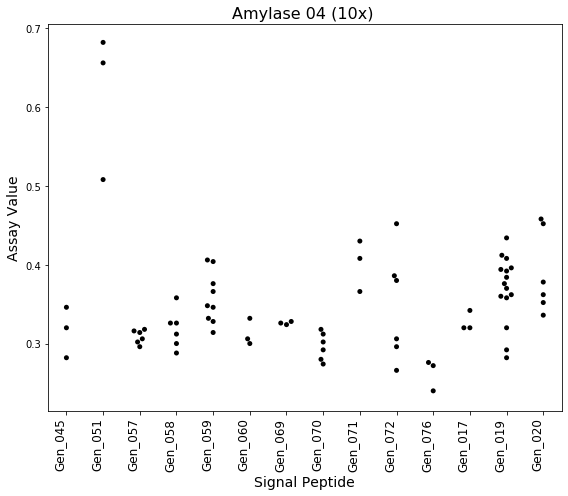

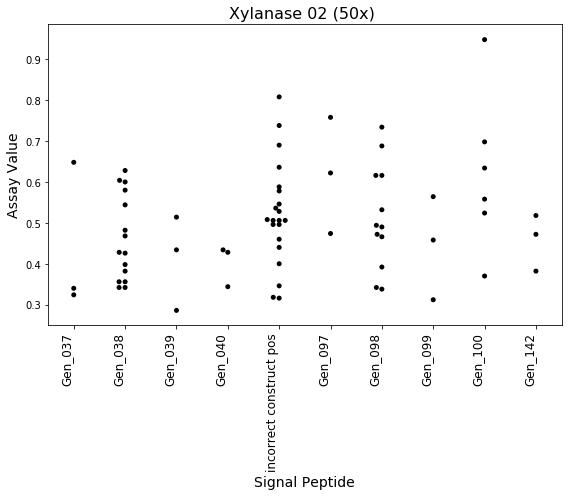

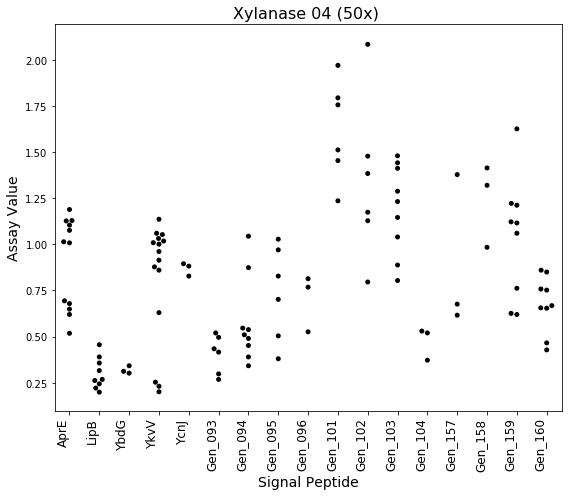

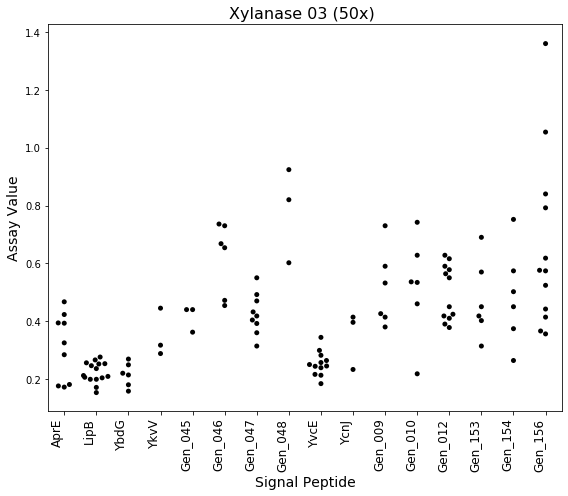

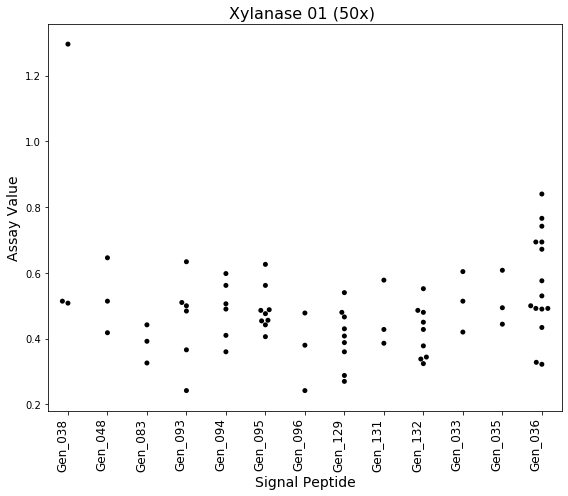

In [14]:
for fam in prot_fams:
    fam_df = tidy_df[tidy_df['family'] == fam]
    
    seqs = list(set(fam_df['seqID'].values))
    seqs.sort()
    
    for seq in seqs:
        sub_df = fam_df[fam_df['seqID']==seq]
        entries = list(set(sub_df['run_id'].values))
        if len(entries) > 1:
            fig, ax = pyplot.subplots(figsize=(8,7))
            chart = sns.swarmplot(ax=ax, x="plot_id", y="assay_value", data=sub_df, color='black')
            chart.set_title(fam + " controls")
            chart.set_xticklabels(
                    chart.get_xticklabels(), 
                    rotation=90, 
                    horizontalalignment='right',
                    fontweight='light',
                    fontsize='large'
                )
            
            title = seq2newid2[sub_df.iloc[0]['seqID'][3:]]
            filename = title[:]
            
            if title[:3] == 'Xyl':
                title = 'Xylanase ' + title[4:] + ' (50x) '
            elif title[:3] == 'Amy':
                title = 'Amylase ' + title[4:]  + ' (10x) '

            plt.xlabel('Signal Peptide', fontsize=14)
            plt.ylabel('Assay Value', fontsize=14)
            plt.title(title, fontsize=16)
        
            plt.tight_layout()
            plt.savefig('data/figs/higher_dilution/' + filename + '.svg')

    #         plt.legend().set_visible(False)

    #         except ValueError:
    #             print(f"{fam} cannot be plotted")
